In [ ]:
import sys
sys.path.append("..\\backtesting\\utils")
import dynamic_backtesting as db
import compare_strategies as cs
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib
import numpy as np
from matplotlib.dates import DateFormatter
from matplotlib.dates import YearLocator
plt.style.use('seaborn')
matplotlib.rcParams['axes.prop_cycle'] = matplotlib.cycler(color=["grey", "green", "black", "deepskyblue", "orange", "lime", "purple", "Gold", "brown", "blue", "pink"])
plt.rcParams.update({
   "text.usetex": True,
   "font.family": ['Latin Modern Roman'],
   "xtick.labelsize": 20.0,
   "ytick.labelsize": 20.0,
   "axes.labelsize":  20.0,
   "legend.fontsize": 18.0
})  


In [ ]:
assets = {"EEM": "Emerging Markets",
           "IVV": "S&P 500",
           "IEV": "MSCI Europe",
           "IXN": "Global Tech",
           "IYR": "US Real Estate",
           "IXG": "Global Financials",
           "EXI": "Global Industrials",
           "GC=F": "Gold Futures", 
           "BZ=F": "Brent Crude Oil Futures",
           "HYG": "High-Yield Corporate Bonds",
           "TLT": "20+ Year Treasury Bonds"}
tickers = list(assets.keys())
stocks = tickers[:7]
commodities = tickers[7:9]
bonds = tickers[9:]

**Henter return data udfra tickers**

In [ ]:
return_data =db.download_return_data(tickers)

**Simulere Non central t-fordelinger til $r_t$. Bemærk at disse ikke er dem fra MGARCH modellen**

In [ ]:
#fitter NCT fordeling til return data
t_dist= return_data.apply(scipy.nct.fit, axis=0) 
stat = pd.DataFrame([t_dist.iloc[0],t_dist.iloc[1],t_dist.iloc[2],t_dist.iloc[3]], columns = tickers, index = ['DF','NC','LOC','SCALE']).transpose()

#Sætter længde af simuleringen og random state
T=len(return_data)
state=2016

#Simulere data og ligger det i et dataframe
for index,row in stat.iterrows():
    simulated_returns_1=scipy.nct.rvs(row['DF'],row['NC'],loc=row['LOC'],scale=row['SCALE'],size=T,random_state=state)
    if index=="EEM":
        simulated_returns=pd.DataFrame(simulated_returns_1, columns = ["EEM"])
    else:
        simulated_returns[index]=simulated_returns_1

**Laver funktioner MGARCH model fit og udregning af vægte**

In [ ]:
def GARCH_MODEL(ugarch_model="sGARCH", garch_order=(1, 1)):
    """
    Estimate af GARCH model and parse parameters, sigmas and residuals
    ugarch_model: sGARCH, gjrGARCH
    garch_order: (1, 1), (1,0)
    """
    coef, residuals, sigmas = db.fit_garch_model()
    return coef, residuals, sigmas

In [ ]:
def Simulation_maker(GARCHTYPE,Data, coef, residuals, sigmas):
    """
    Makes data for an simulations with a GARCH type model using the data in the csv file and simulation

    Variables:
    GARCHTYPE: sGARCH11, sGARCH10, gjrGARCH11
    Data: Data used to find Omega_t to the simulated data
    Residuals: Past residuals
    Sigmas: Past sigmas
    """
    #unpacks paramters
    params_dict = db.parse_garch_coef(coef, 11, GARCHTYPE)
    #udregner omega
    sim_omega_s=db.calc_Omega_ts(Data,sigmas,residuals, **params_dict)
    #udregner vægte
    sim_weights=db.calc_weights_garch_no_trading_cost(sim_omega_s)
    return sim_weights

Simulating med $t_v$-distributed returns

In [ ]:
#v_t_ARCH_t, out_of_sample_ARCH_t, _, Omega_ts_ARCH_T = db.garch_with_trading_cost(tickers, number_of_out_of_sample_days=4*250, model_type="sGARCH10",tuning_gamma_D=None, simulation=True, ugarch_dist_model="std")
v_t_GARCH_t, out_of_sample_GARCH_t, _, Omega_ts_GARCH_T = db.garch_with_trading_cost(tickers, number_of_out_of_sample_days=4*250, model_type="sGARCH11",tuning_gamma_D=None, simulation=True, ugarch_dist_model="std")
#v_t_GJR_t, out_of_sample_GJR_t, _, Omega_ts_GJR_T = db.garch_with_trading_cost(tickers, number_of_out_of_sample_days=4*250, model_type="gjrGARCH11",tuning_gamma_D=None, simulation=True, ugarch_dist_model="std")

In [ ]:
#res_ARCH_t, perf_table_ARCH_t = cs.performance_table(v_t_ARCH_t, out_of_sample_ARCH_t,Omega_ts_ARCH_T,portfolio_value=1e9)
res_GARCH_t, perf_table_GARCH_t = cs.performance_table(v_t_GARCH_t, out_of_sample_GARCH_t,Omega_ts_GARCH_T,portfolio_value=1e9)
#res_GJR_t, perf_table_GJR_t = cs.performance_table(v_t_GJR_t, out_of_sample_GJR_t,Omega_ts_GJR_T,portfolio_value=1e9)

In [ ]:
out_of_sample_GARCH_t.index = pd.to_datetime(out_of_sample_GARCH_t.index)
fig, ax = plt.subplots(1, 1, figsize=(9,7), dpi=300)
ax.plot(out_of_sample_GARCH_t["IEV"])
ax.xaxis.set_major_locator(YearLocator())
ax.xaxis.set_major_formatter(DateFormatter("%Y"))

In [ ]:
perf_total_TC=[]
perf_total= []

In [ ]:
for seed in range(10,15):
    v_t, out_of_sample, _,  Omega_ts= db.garch_with_trading_cost(tickers, number_of_out_of_sample_days=4*250, model_type="sGARCH11",tuning_gamma_D=None, simulation=True, ugarch_dist_model="std",rseed=seed)
    res, perf_table = cs.performance_table(v_t, out_of_sample,Omega_ts,portfolio_value=1e9)
    perf_table["seed"]=seed
    perf_total.append(perf_table.loc["GARCH"])
    perf_total_TC.append(perf_table.loc["GARCH TC"])

In [ ]:
test=pd.DataFrame(perf_total).set_index('seed')

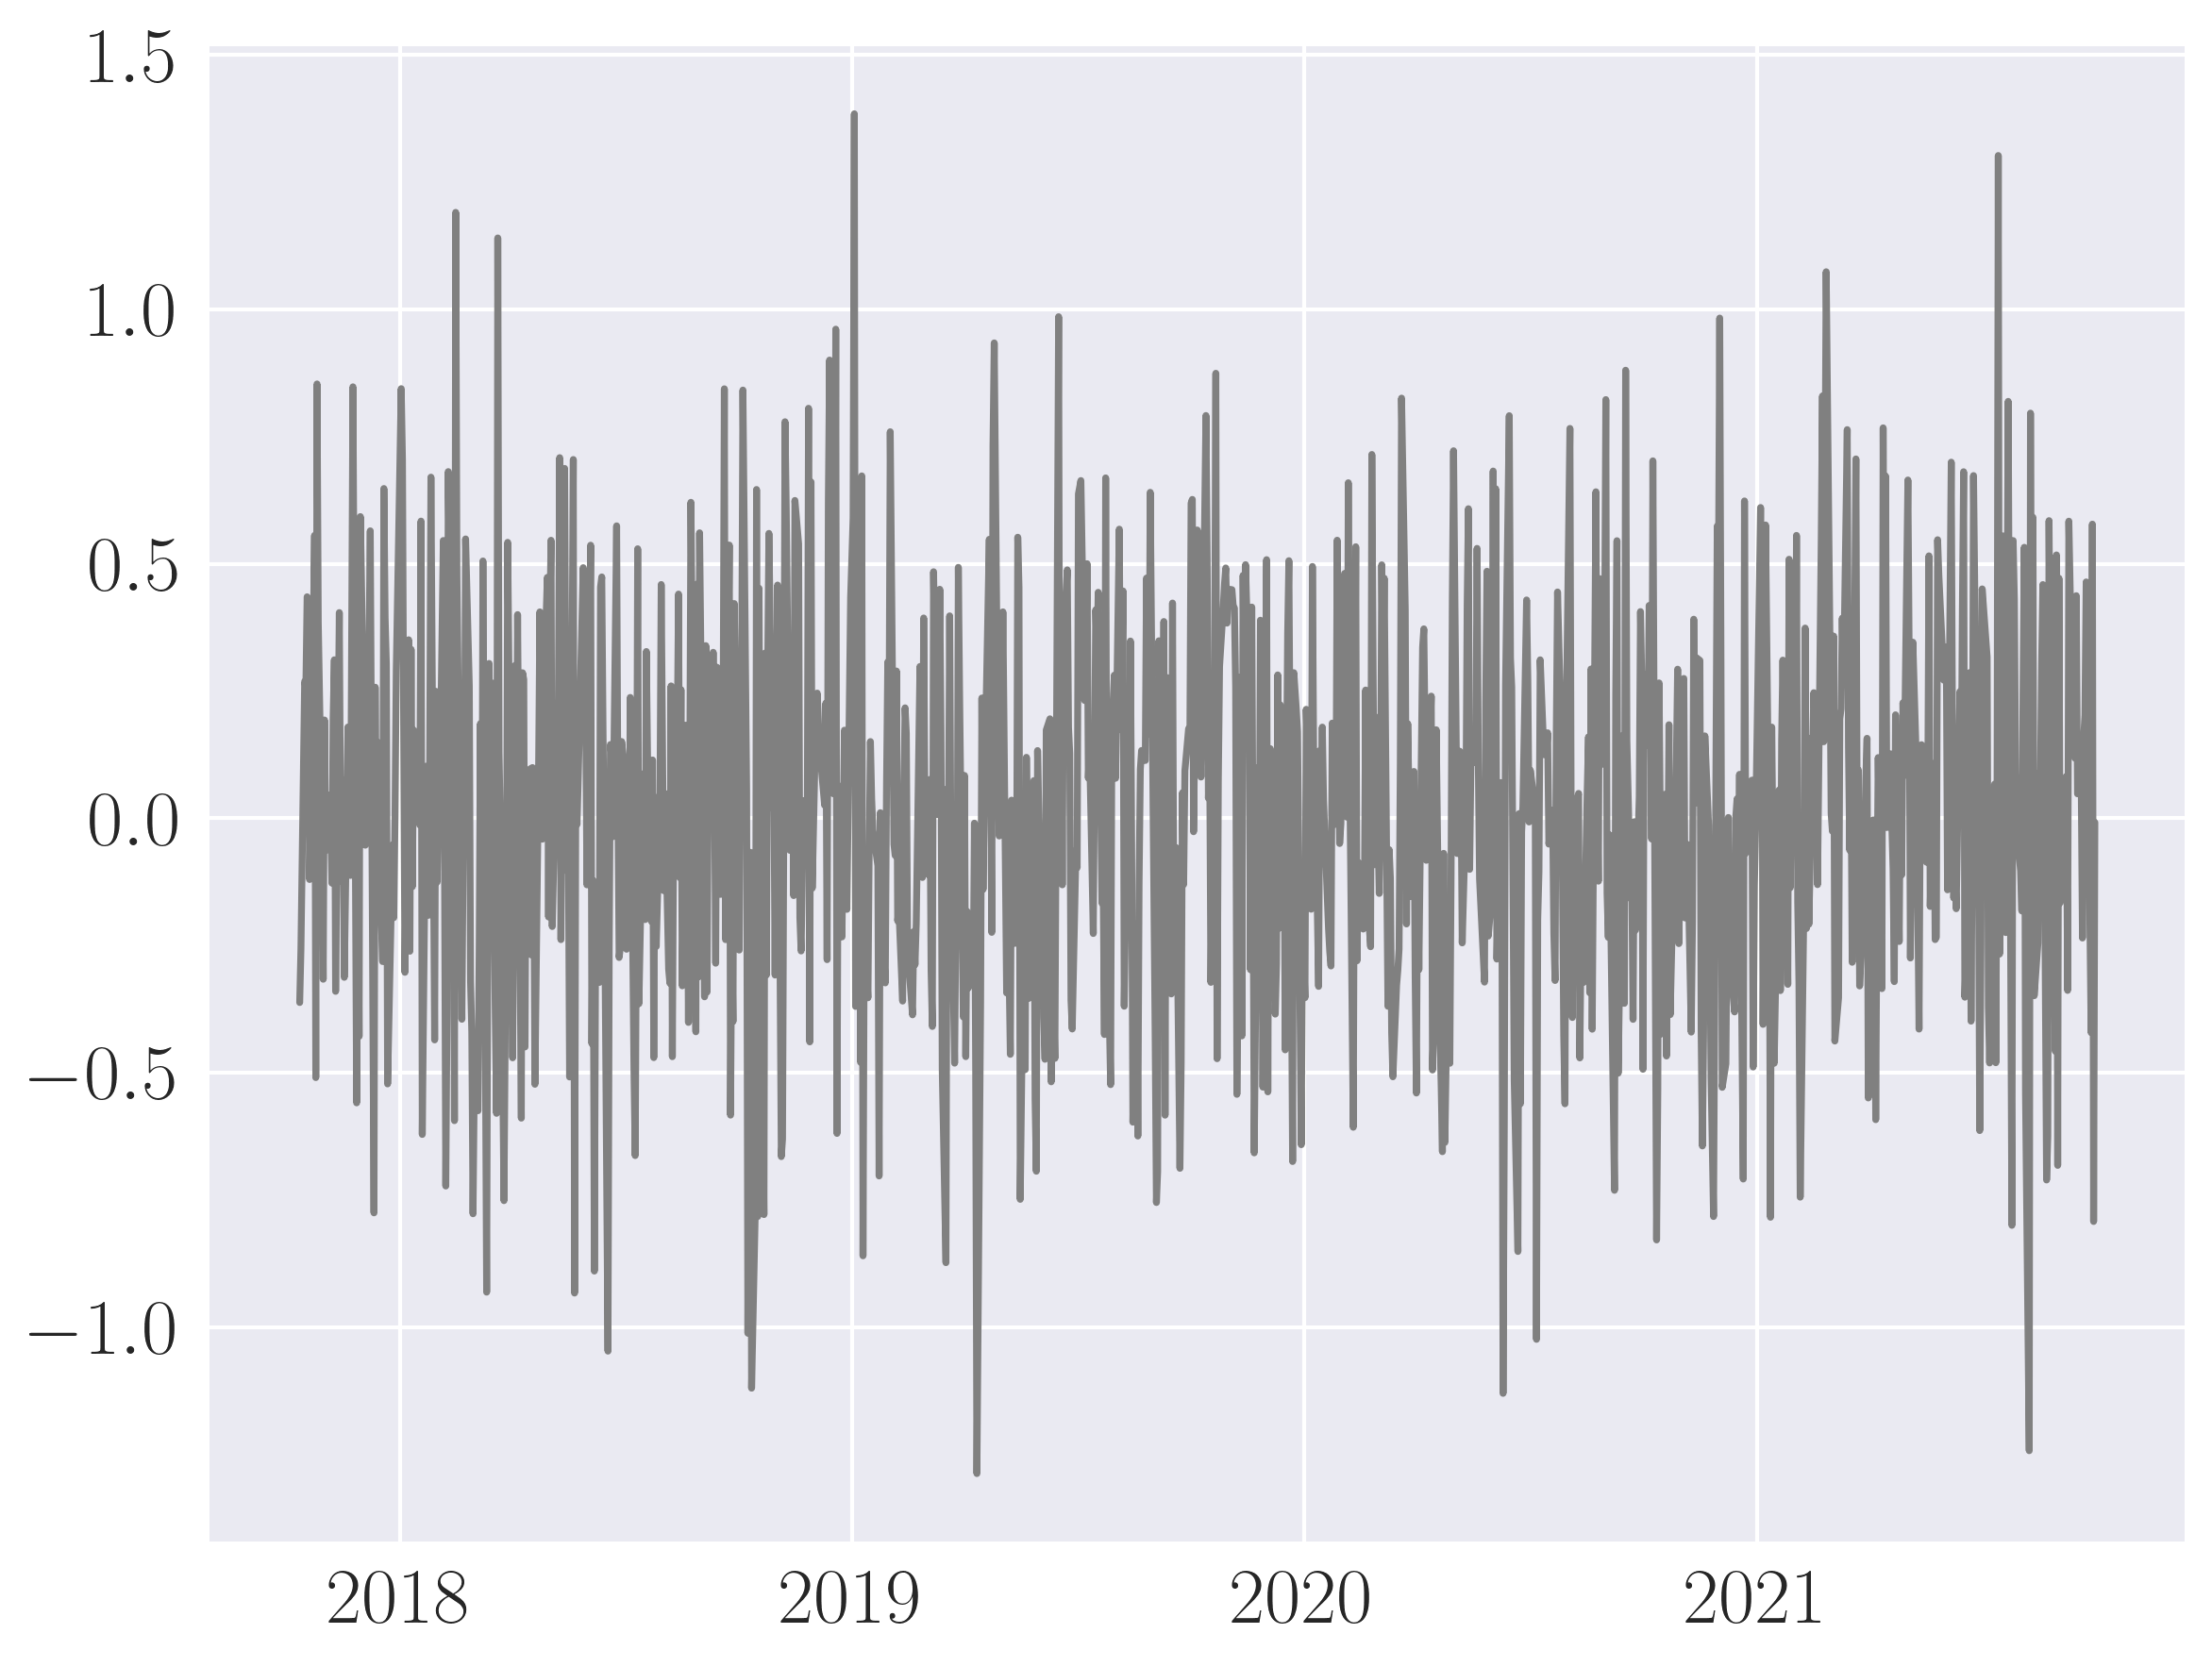

In [13]:
out_of_sample.index = pd.to_datetime(out_of_sample.index)
fig, ax = plt.subplots(1, 1, figsize=(9,7), dpi=300)
ax.plot(out_of_sample["TLT"])
ax.xaxis.set_major_locator(YearLocator())
ax.xaxis.set_major_formatter(DateFormatter("%Y"))

Simulating med Gaussian returns

In [ ]:
v_t_ARCH_n, out_of_sample_ARCH_n, _, Omega_ts_ARCH_n = db.garch_with_trading_cost(tickers, number_of_out_of_sample_days=4*250,
 model_type="sGARCH10",tuning_gamma_D=None, simulation=True, ugarch_dist_model="norm")
v_t_GARCH_n, out_of_sample_GARCH_n, _, Omega_ts_GARCH_n = db.garch_with_trading_cost(tickers, number_of_out_of_sample_days=4*250,
 model_type="sGARCH11",tuning_gamma_D=None, simulation=True, ugarch_dist_model="norm")
v_t_GJR_n, out_of_sample_GJR_n, _, Omega_ts_GJR_n = db.garch_with_trading_cost(tickers, number_of_out_of_sample_days=4*250,
 model_type="gjrGARCH11",tuning_gamma_D=None, simulation=True, ugarch_dist_model="norm")

In [ ]:
res_ARCH_n, perf_table_ARCH_n = cs.performance_table(v_t_ARCH_n, out_of_sample_ARCH_n,Omega_ts_ARCH_n,portfolio_value=1e9)
res_GARCH_n, perf_table_GARCH_n = cs.performance_table(v_t_GARCH_n, out_of_sample_GARCH_n,Omega_ts_GARCH_n,portfolio_value=1e9)
res_GJR_n, perf_table_GJR_t = cs.performance_table(v_t_GJR_n, out_of_sample_GJR_n,Omega_ts_GJR_n,portfolio_value=1e9)

In [ ]:
out_of_sample_ARCH_n.index = pd.to_datetime(out_of_sample_ARCH_n.index)
fig, ax = plt.subplots(1, 1, figsize=(9,7), dpi=300)
ax.plot(out_of_sample_GJR_n["IVV"])
ax.xaxis.set_major_locator(YearLocator())
ax.xaxis.set_major_formatter(DateFormatter("%Y"))

In [ ]:
Omega_ts_ARCH_T